# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

In [ ]:
from torch.utils.tensorboard import SummaryWriter
os.system('rm -r runs')
print('removing previos run dir')
writer = SummaryWriter()

removing previos run dir


### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f9604458-3998-bdd9-ea80-2f1574c1a702)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

100%|██████████| 170498071/170498071 [00:13<00:00, 12277498.95it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset) / 2
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch  1: Loss = 1.7120 Acc = 0.37 Test_Loss = 1.5261 Test_Acc = 0.44


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


Epoch  2: Loss = 1.3985 Acc = 0.49 Test_Loss = 1.3674 Test_Acc = 0.51


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch  3: Loss = 1.2547 Acc = 0.55 Test_Loss = 1.2461 Test_Acc = 0.57


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch  4: Loss = 1.1345 Acc = 0.59 Test_Loss = 1.2532 Test_Acc = 0.57


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch  5: Loss = 1.0611 Acc = 0.62 Test_Loss = 1.0662 Test_Acc = 0.63


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch  6: Loss = 1.0039 Acc = 0.64 Test_Loss = 0.9802 Test_Acc = 0.65


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch  7: Loss = 0.9465 Acc = 0.66 Test_Loss = 0.9443 Test_Acc = 0.67


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Epoch  8: Loss = 0.9153 Acc = 0.67 Test_Loss = 0.9489 Test_Acc = 0.67


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch  9: Loss = 0.8719 Acc = 0.69 Test_Loss = 0.9215 Test_Acc = 0.68


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 10: Loss = 0.8294 Acc = 0.71 Test_Loss = 0.8209 Test_Acc = 0.71


100%|██████████| 40/40 [00:03<00:00, 10.54it/s]


Epoch 11: Loss = 0.8139 Acc = 0.71 Test_Loss = 0.8273 Test_Acc = 0.72


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 12: Loss = 0.7964 Acc = 0.72 Test_Loss = 0.7757 Test_Acc = 0.73


100%|██████████| 40/40 [00:02<00:00, 14.00it/s]


Epoch 13: Loss = 0.7452 Acc = 0.74 Test_Loss = 0.8070 Test_Acc = 0.72


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 14: Loss = 0.7309 Acc = 0.74 Test_Loss = 0.8654 Test_Acc = 0.71


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 15: Loss = 0.7253 Acc = 0.75 Test_Loss = 0.7549 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 16: Loss = 0.6894 Acc = 0.75 Test_Loss = 0.6791 Test_Acc = 0.77


100%|██████████| 40/40 [00:03<00:00, 12.26it/s]


Epoch 17: Loss = 0.6860 Acc = 0.76 Test_Loss = 0.7429 Test_Acc = 0.75


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 18: Loss = 0.6570 Acc = 0.77 Test_Loss = 0.7041 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 12.00it/s]


Epoch 19: Loss = 0.6383 Acc = 0.77 Test_Loss = 0.6865 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 12.35it/s]


Epoch 20: Loss = 0.6295 Acc = 0.78 Test_Loss = 0.6748 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 21: Loss = 0.6153 Acc = 0.79 Test_Loss = 0.6397 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


Epoch 22: Loss = 0.6017 Acc = 0.79 Test_Loss = 0.6749 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


Epoch 23: Loss = 0.5890 Acc = 0.79 Test_Loss = 0.6503 Test_Acc = 0.78


100%|██████████| 40/40 [00:02<00:00, 13.34it/s]


Epoch 24: Loss = 0.5682 Acc = 0.80 Test_Loss = 0.7525 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 10.50it/s]


Epoch 25: Loss = 0.5598 Acc = 0.81 Test_Loss = 0.6834 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


Epoch 26: Loss = 0.5506 Acc = 0.81 Test_Loss = 0.7454 Test_Acc = 0.75


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 27: Loss = 0.5598 Acc = 0.80 Test_Loss = 0.6503 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.99it/s]


Epoch 28: Loss = 0.5506 Acc = 0.81 Test_Loss = 0.6660 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 29: Loss = 0.5395 Acc = 0.81 Test_Loss = 0.6163 Test_Acc = 0.79


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 30: Loss = 0.5258 Acc = 0.81 Test_Loss = 0.6430 Test_Acc = 0.78


100%|██████████| 40/40 [00:04<00:00,  9.95it/s]


Epoch 31: Loss = 0.5170 Acc = 0.82 Test_Loss = 0.6512 Test_Acc = 0.79


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 32: Loss = 0.4958 Acc = 0.83 Test_Loss = 0.6813 Test_Acc = 0.77


100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


Epoch 33: Loss = 0.4866 Acc = 0.83 Test_Loss = 0.6397 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


Epoch 34: Loss = 0.4922 Acc = 0.83 Test_Loss = 0.5916 Test_Acc = 0.80


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 35: Loss = 0.4812 Acc = 0.83 Test_Loss = 0.6355 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 11.24it/s]


Epoch 36: Loss = 0.4764 Acc = 0.83 Test_Loss = 0.6223 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch 37: Loss = 0.4679 Acc = 0.83 Test_Loss = 0.5902 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]


Epoch 38: Loss = 0.4523 Acc = 0.84 Test_Loss = 0.5920 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch 39: Loss = 0.4576 Acc = 0.84 Test_Loss = 0.6641 Test_Acc = 0.78


100%|██████████| 40/40 [00:02<00:00, 13.93it/s]


Epoch 40: Loss = 0.4561 Acc = 0.84 Test_Loss = 0.6118 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch 41: Loss = 0.4360 Acc = 0.85 Test_Loss = 0.5704 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.30it/s]


Epoch 42: Loss = 0.4317 Acc = 0.85 Test_Loss = 0.6095 Test_Acc = 0.80


100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 43: Loss = 0.4329 Acc = 0.85 Test_Loss = 0.6146 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.23it/s]


Epoch 44: Loss = 0.4251 Acc = 0.85 Test_Loss = 0.5475 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]


Epoch 45: Loss = 0.4171 Acc = 0.85 Test_Loss = 0.5997 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 46: Loss = 0.4061 Acc = 0.86 Test_Loss = 0.5571 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 47: Loss = 0.4025 Acc = 0.86 Test_Loss = 0.5623 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 48: Loss = 0.4054 Acc = 0.86 Test_Loss = 0.5818 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 49: Loss = 0.4059 Acc = 0.86 Test_Loss = 0.5651 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


Epoch 50: Loss = 0.4028 Acc = 0.86 Test_Loss = 0.5736 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 51: Loss = 0.3805 Acc = 0.86 Test_Loss = 0.5607 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.74it/s]


Epoch 52: Loss = 0.3820 Acc = 0.86 Test_Loss = 0.5719 Test_Acc = 0.81


100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


Epoch 53: Loss = 0.3782 Acc = 0.87 Test_Loss = 0.5688 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 54: Loss = 0.3652 Acc = 0.87 Test_Loss = 0.5489 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.98it/s]


Epoch 55: Loss = 0.3606 Acc = 0.87 Test_Loss = 0.5655 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 56: Loss = 0.3675 Acc = 0.87 Test_Loss = 0.5960 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 57: Loss = 0.3622 Acc = 0.87 Test_Loss = 0.6001 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 12.80it/s]


Epoch 58: Loss = 0.3535 Acc = 0.87 Test_Loss = 0.5578 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 59: Loss = 0.3496 Acc = 0.88 Test_Loss = 0.5492 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 60: Loss = 0.3448 Acc = 0.88 Test_Loss = 0.6002 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 11.94it/s]


Epoch 61: Loss = 0.3466 Acc = 0.88 Test_Loss = 0.5721 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Epoch 62: Loss = 0.3336 Acc = 0.88 Test_Loss = 0.5575 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 63: Loss = 0.3295 Acc = 0.88 Test_Loss = 0.5783 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


Epoch 64: Loss = 0.3247 Acc = 0.88 Test_Loss = 0.5665 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch 65: Loss = 0.3230 Acc = 0.89 Test_Loss = 0.5720 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 66: Loss = 0.3177 Acc = 0.89 Test_Loss = 0.5924 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


Epoch 67: Loss = 0.3172 Acc = 0.89 Test_Loss = 0.5434 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 68: Loss = 0.3108 Acc = 0.89 Test_Loss = 0.5887 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


Epoch 69: Loss = 0.3163 Acc = 0.89 Test_Loss = 0.5492 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 70: Loss = 0.3093 Acc = 0.89 Test_Loss = 0.5566 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 71: Loss = 0.3018 Acc = 0.89 Test_Loss = 0.5463 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 72: Loss = 0.2911 Acc = 0.90 Test_Loss = 0.5599 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 73: Loss = 0.3054 Acc = 0.89 Test_Loss = 0.6329 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 74: Loss = 0.2969 Acc = 0.89 Test_Loss = 0.5343 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 75: Loss = 0.2823 Acc = 0.90 Test_Loss = 0.5565 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Epoch 76: Loss = 0.2720 Acc = 0.90 Test_Loss = 0.5896 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 77: Loss = 0.2823 Acc = 0.90 Test_Loss = 0.5704 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 78: Loss = 0.2796 Acc = 0.90 Test_Loss = 0.5821 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 13.08it/s]


Epoch 79: Loss = 0.2793 Acc = 0.90 Test_Loss = 0.5622 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.52it/s]


Epoch 80: Loss = 0.2713 Acc = 0.90 Test_Loss = 0.5578 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 81: Loss = 0.2679 Acc = 0.90 Test_Loss = 0.5798 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 82: Loss = 0.2667 Acc = 0.91 Test_Loss = 0.5851 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 83: Loss = 0.2662 Acc = 0.91 Test_Loss = 0.5725 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Epoch 84: Loss = 0.2607 Acc = 0.91 Test_Loss = 0.5659 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 85: Loss = 0.2494 Acc = 0.91 Test_Loss = 0.5998 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 86: Loss = 0.2571 Acc = 0.91 Test_Loss = 0.5691 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


Epoch 87: Loss = 0.2453 Acc = 0.91 Test_Loss = 0.5807 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 88: Loss = 0.2465 Acc = 0.91 Test_Loss = 0.5818 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 89: Loss = 0.2450 Acc = 0.91 Test_Loss = 0.5804 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


Epoch 90: Loss = 0.2446 Acc = 0.91 Test_Loss = 0.5726 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 91: Loss = 0.2392 Acc = 0.92 Test_Loss = 0.6018 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.45it/s]


Epoch 92: Loss = 0.2381 Acc = 0.92 Test_Loss = 0.5640 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 93: Loss = 0.2259 Acc = 0.92 Test_Loss = 0.5885 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 94: Loss = 0.2303 Acc = 0.92 Test_Loss = 0.5862 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 95: Loss = 0.2351 Acc = 0.92 Test_Loss = 0.5787 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.94it/s]


Epoch 96: Loss = 0.2282 Acc = 0.92 Test_Loss = 0.5534 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.98it/s]


Epoch 97: Loss = 0.2180 Acc = 0.92 Test_Loss = 0.5890 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch 98: Loss = 0.2217 Acc = 0.92 Test_Loss = 0.5740 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


Epoch 99: Loss = 0.2177 Acc = 0.92 Test_Loss = 0.6048 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Epoch 100: Loss = 0.2240 Acc = 0.92 Test_Loss = 0.5790 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.45it/s]


Epoch 101: Loss = 0.2158 Acc = 0.92 Test_Loss = 0.5751 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.75it/s]


Epoch 102: Loss = 0.2177 Acc = 0.92 Test_Loss = 0.5962 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 103: Loss = 0.2130 Acc = 0.92 Test_Loss = 0.6033 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Epoch 104: Loss = 0.2128 Acc = 0.92 Test_Loss = 0.6071 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.43it/s]


Epoch 105: Loss = 0.2091 Acc = 0.92 Test_Loss = 0.6127 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.07it/s]


Epoch 106: Loss = 0.2000 Acc = 0.93 Test_Loss = 0.6025 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.30it/s]


Epoch 107: Loss = 0.1966 Acc = 0.93 Test_Loss = 0.6504 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 108: Loss = 0.1970 Acc = 0.93 Test_Loss = 0.6266 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 109: Loss = 0.2068 Acc = 0.93 Test_Loss = 0.5915 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 110: Loss = 0.1951 Acc = 0.93 Test_Loss = 0.6086 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 111: Loss = 0.1926 Acc = 0.93 Test_Loss = 0.6065 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 112: Loss = 0.1962 Acc = 0.93 Test_Loss = 0.5852 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.63it/s]


Epoch 113: Loss = 0.1969 Acc = 0.93 Test_Loss = 0.5937 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 114: Loss = 0.1864 Acc = 0.93 Test_Loss = 0.6360 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 115: Loss = 0.1914 Acc = 0.93 Test_Loss = 0.6675 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 116: Loss = 0.1872 Acc = 0.93 Test_Loss = 0.6034 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.25it/s]


Epoch 117: Loss = 0.1847 Acc = 0.93 Test_Loss = 0.6264 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.36it/s]


Epoch 118: Loss = 0.1751 Acc = 0.94 Test_Loss = 0.6155 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


Epoch 119: Loss = 0.1761 Acc = 0.94 Test_Loss = 0.6423 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 120: Loss = 0.1910 Acc = 0.93 Test_Loss = 0.6260 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 121: Loss = 0.1757 Acc = 0.94 Test_Loss = 0.6302 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.19it/s]


Epoch 122: Loss = 0.1735 Acc = 0.94 Test_Loss = 0.5980 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.79it/s]


Epoch 123: Loss = 0.1693 Acc = 0.94 Test_Loss = 0.6612 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 124: Loss = 0.1772 Acc = 0.94 Test_Loss = 0.6097 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.25it/s]


Epoch 125: Loss = 0.1620 Acc = 0.94 Test_Loss = 0.6690 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 126: Loss = 0.1784 Acc = 0.94 Test_Loss = 0.6249 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Epoch 127: Loss = 0.1604 Acc = 0.94 Test_Loss = 0.6456 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 128: Loss = 0.1642 Acc = 0.94 Test_Loss = 0.6735 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.95it/s]


Epoch 129: Loss = 0.1716 Acc = 0.94 Test_Loss = 0.6517 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 130: Loss = 0.1637 Acc = 0.94 Test_Loss = 0.6507 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


Epoch 131: Loss = 0.1627 Acc = 0.94 Test_Loss = 0.6507 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 132: Loss = 0.1644 Acc = 0.94 Test_Loss = 0.6278 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 133: Loss = 0.1572 Acc = 0.94 Test_Loss = 0.6397 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 134: Loss = 0.1573 Acc = 0.94 Test_Loss = 0.6174 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 135: Loss = 0.1492 Acc = 0.95 Test_Loss = 0.6360 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


Epoch 136: Loss = 0.1557 Acc = 0.94 Test_Loss = 0.6547 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.58it/s]


Epoch 137: Loss = 0.1501 Acc = 0.95 Test_Loss = 0.6320 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 138: Loss = 0.1599 Acc = 0.94 Test_Loss = 0.6642 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 139: Loss = 0.1439 Acc = 0.95 Test_Loss = 0.6614 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.14it/s]


Epoch 140: Loss = 0.1543 Acc = 0.94 Test_Loss = 0.6708 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 141: Loss = 0.1459 Acc = 0.95 Test_Loss = 0.6374 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.99it/s]


Epoch 142: Loss = 0.1403 Acc = 0.95 Test_Loss = 0.6504 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.48it/s]


Epoch 143: Loss = 0.1446 Acc = 0.95 Test_Loss = 0.6245 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 144: Loss = 0.1527 Acc = 0.95 Test_Loss = 0.6255 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 145: Loss = 0.1426 Acc = 0.95 Test_Loss = 0.6372 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.99it/s]


Epoch 146: Loss = 0.1452 Acc = 0.95 Test_Loss = 0.6938 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.65it/s]


Epoch 147: Loss = 0.1412 Acc = 0.95 Test_Loss = 0.6514 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.14it/s]


Epoch 148: Loss = 0.1458 Acc = 0.95 Test_Loss = 0.6921 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


Epoch 149: Loss = 0.1343 Acc = 0.95 Test_Loss = 0.6512 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Epoch 150: Loss = 0.1348 Acc = 0.95 Test_Loss = 0.6673 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.22it/s]


Epoch 151: Loss = 0.1353 Acc = 0.95 Test_Loss = 0.6375 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]


Epoch 152: Loss = 0.1338 Acc = 0.95 Test_Loss = 0.6559 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.54it/s]


Epoch 153: Loss = 0.1308 Acc = 0.95 Test_Loss = 0.6935 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.33it/s]


Epoch 154: Loss = 0.1368 Acc = 0.95 Test_Loss = 0.6468 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.00it/s]


Epoch 155: Loss = 0.1280 Acc = 0.95 Test_Loss = 0.6650 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 156: Loss = 0.1305 Acc = 0.95 Test_Loss = 0.6918 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Epoch 157: Loss = 0.1264 Acc = 0.95 Test_Loss = 0.6595 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


Epoch 158: Loss = 0.1360 Acc = 0.95 Test_Loss = 0.6898 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.28it/s]


Epoch 159: Loss = 0.1330 Acc = 0.95 Test_Loss = 0.7012 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 160: Loss = 0.1266 Acc = 0.96 Test_Loss = 0.6790 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch 161: Loss = 0.1287 Acc = 0.95 Test_Loss = 0.6893 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 162: Loss = 0.1346 Acc = 0.95 Test_Loss = 0.6818 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 163: Loss = 0.1286 Acc = 0.95 Test_Loss = 0.7066 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch 164: Loss = 0.1302 Acc = 0.95 Test_Loss = 0.6474 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.27it/s]


Epoch 165: Loss = 0.1203 Acc = 0.96 Test_Loss = 0.6988 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


Epoch 166: Loss = 0.1158 Acc = 0.96 Test_Loss = 0.6880 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 167: Loss = 0.1168 Acc = 0.96 Test_Loss = 0.7178 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.93it/s]


Epoch 168: Loss = 0.1131 Acc = 0.96 Test_Loss = 0.7047 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


Epoch 169: Loss = 0.1244 Acc = 0.96 Test_Loss = 0.7474 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.85it/s]


Epoch 170: Loss = 0.1138 Acc = 0.96 Test_Loss = 0.7457 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.48it/s]


Epoch 171: Loss = 0.1245 Acc = 0.96 Test_Loss = 0.6918 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 172: Loss = 0.1167 Acc = 0.96 Test_Loss = 0.6996 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 173: Loss = 0.1157 Acc = 0.96 Test_Loss = 0.7073 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 174: Loss = 0.1196 Acc = 0.96 Test_Loss = 0.7386 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 175: Loss = 0.1177 Acc = 0.96 Test_Loss = 0.7015 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.20it/s]


Epoch 176: Loss = 0.1121 Acc = 0.96 Test_Loss = 0.7612 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.36it/s]


Epoch 177: Loss = 0.1158 Acc = 0.96 Test_Loss = 0.7318 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 178: Loss = 0.1103 Acc = 0.96 Test_Loss = 0.6841 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.98it/s]


Epoch 179: Loss = 0.1030 Acc = 0.96 Test_Loss = 0.7370 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.34it/s]


Epoch 180: Loss = 0.1106 Acc = 0.96 Test_Loss = 0.7169 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Epoch 181: Loss = 0.1149 Acc = 0.96 Test_Loss = 0.7256 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


Epoch 182: Loss = 0.1102 Acc = 0.96 Test_Loss = 0.7001 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


Epoch 183: Loss = 0.1049 Acc = 0.96 Test_Loss = 0.7318 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 184: Loss = 0.1130 Acc = 0.96 Test_Loss = 0.7035 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 14.12it/s]


Epoch 185: Loss = 0.1021 Acc = 0.96 Test_Loss = 0.6983 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch 186: Loss = 0.1105 Acc = 0.96 Test_Loss = 0.7146 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.34it/s]


Epoch 187: Loss = 0.1068 Acc = 0.96 Test_Loss = 0.7235 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.47it/s]


Epoch 188: Loss = 0.1077 Acc = 0.96 Test_Loss = 0.7049 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]


Epoch 189: Loss = 0.1041 Acc = 0.96 Test_Loss = 0.7125 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 190: Loss = 0.1098 Acc = 0.96 Test_Loss = 0.6955 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.80it/s]


Epoch 191: Loss = 0.1015 Acc = 0.96 Test_Loss = 0.6940 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


Epoch 192: Loss = 0.1060 Acc = 0.96 Test_Loss = 0.7331 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 193: Loss = 0.0954 Acc = 0.97 Test_Loss = 0.7805 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


Epoch 194: Loss = 0.0968 Acc = 0.97 Test_Loss = 0.7122 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.01it/s]


Epoch 195: Loss = 0.1014 Acc = 0.96 Test_Loss = 0.7313 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 196: Loss = 0.1065 Acc = 0.96 Test_Loss = 0.7318 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 197: Loss = 0.1014 Acc = 0.96 Test_Loss = 0.7509 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 198: Loss = 0.1016 Acc = 0.96 Test_Loss = 0.7976 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.43it/s]


Epoch 199: Loss = 0.0984 Acc = 0.96 Test_Loss = 0.7347 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]

Epoch 200: Loss = 0.0954 Acc = 0.97 Test_Loss = 0.7383 Test_Acc = 0.84


In [ ]:
print(best_acc)

0.8485


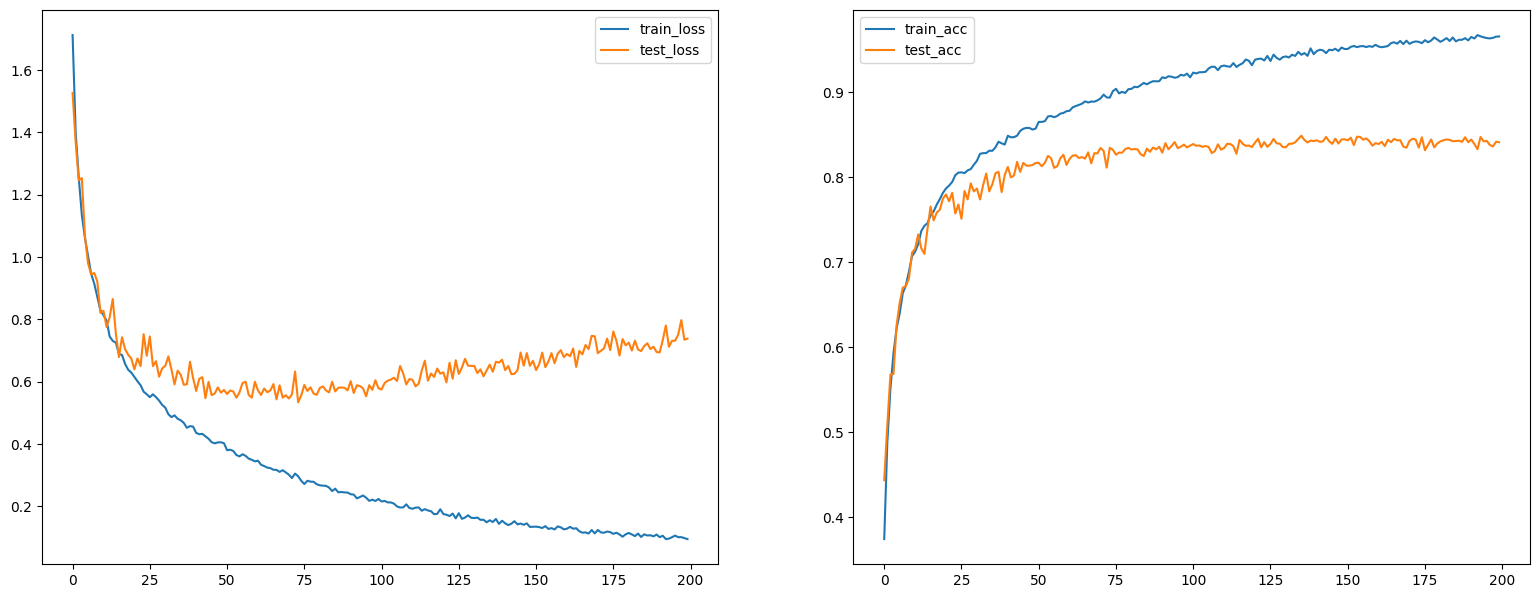

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
model.fc = nn.Linear(model.fc.in_features, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 200

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(half_train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/test', test_acc, epoch)

writer.close()

100%|██████████| 40/40 [00:03<00:00, 12.56it/s]


Epoch  1: Loss = 1.1948 Acc = 0.58 Test_Loss = 0.8625 Test_Acc = 0.71


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch  2: Loss = 0.8159 Acc = 0.72 Test_Loss = 0.7488 Test_Acc = 0.74


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch  3: Loss = 0.7091 Acc = 0.76 Test_Loss = 0.7370 Test_Acc = 0.75


100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


Epoch  4: Loss = 0.6606 Acc = 0.78 Test_Loss = 0.7202 Test_Acc = 0.76


100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


Epoch  5: Loss = 0.6225 Acc = 0.79 Test_Loss = 0.6301 Test_Acc = 0.79


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Epoch  6: Loss = 0.5860 Acc = 0.80 Test_Loss = 0.6715 Test_Acc = 0.78


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch  7: Loss = 0.5633 Acc = 0.81 Test_Loss = 0.6040 Test_Acc = 0.80


100%|██████████| 40/40 [00:02<00:00, 13.90it/s]


Epoch  8: Loss = 0.5431 Acc = 0.81 Test_Loss = 0.6320 Test_Acc = 0.80


100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch  9: Loss = 0.5238 Acc = 0.82 Test_Loss = 0.5643 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.39it/s]


Epoch 10: Loss = 0.4934 Acc = 0.83 Test_Loss = 0.6569 Test_Acc = 0.79


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 11: Loss = 0.4857 Acc = 0.83 Test_Loss = 0.5772 Test_Acc = 0.81


100%|██████████| 40/40 [00:03<00:00, 10.39it/s]


Epoch 12: Loss = 0.4627 Acc = 0.84 Test_Loss = 0.5632 Test_Acc = 0.81


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 13: Loss = 0.4599 Acc = 0.84 Test_Loss = 0.5555 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


Epoch 14: Loss = 0.4490 Acc = 0.84 Test_Loss = 0.6174 Test_Acc = 0.80


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 15: Loss = 0.4345 Acc = 0.85 Test_Loss = 0.5609 Test_Acc = 0.82


100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Epoch 16: Loss = 0.4254 Acc = 0.85 Test_Loss = 0.5250 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 12.88it/s]


Epoch 17: Loss = 0.4155 Acc = 0.86 Test_Loss = 0.5507 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 11.66it/s]


Epoch 18: Loss = 0.4109 Acc = 0.86 Test_Loss = 0.5003 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.73it/s]


Epoch 19: Loss = 0.4015 Acc = 0.86 Test_Loss = 0.5133 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.04it/s]


Epoch 20: Loss = 0.3969 Acc = 0.86 Test_Loss = 0.5375 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 12.37it/s]


Epoch 21: Loss = 0.3794 Acc = 0.87 Test_Loss = 0.5261 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.43it/s]


Epoch 22: Loss = 0.3712 Acc = 0.87 Test_Loss = 0.5500 Test_Acc = 0.82


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Epoch 23: Loss = 0.3959 Acc = 0.87 Test_Loss = 0.4922 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.33it/s]


Epoch 24: Loss = 0.3649 Acc = 0.88 Test_Loss = 0.4976 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.83it/s]


Epoch 25: Loss = 0.3575 Acc = 0.88 Test_Loss = 0.4778 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.64it/s]


Epoch 26: Loss = 0.3490 Acc = 0.88 Test_Loss = 0.4829 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 27: Loss = 0.3339 Acc = 0.89 Test_Loss = 0.4901 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 28: Loss = 0.3352 Acc = 0.89 Test_Loss = 0.5078 Test_Acc = 0.84


100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


Epoch 29: Loss = 0.3311 Acc = 0.89 Test_Loss = 0.5272 Test_Acc = 0.83


100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


Epoch 30: Loss = 0.3254 Acc = 0.89 Test_Loss = 0.5070 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.89it/s]


Epoch 31: Loss = 0.3147 Acc = 0.89 Test_Loss = 0.5259 Test_Acc = 0.83


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 32: Loss = 0.3111 Acc = 0.89 Test_Loss = 0.5133 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 33: Loss = 0.2964 Acc = 0.90 Test_Loss = 0.4861 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.78it/s]


Epoch 34: Loss = 0.2982 Acc = 0.90 Test_Loss = 0.5291 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 12.36it/s]


Epoch 35: Loss = 0.3043 Acc = 0.90 Test_Loss = 0.4811 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 36: Loss = 0.2979 Acc = 0.90 Test_Loss = 0.4915 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


Epoch 37: Loss = 0.2968 Acc = 0.90 Test_Loss = 0.4746 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 38: Loss = 0.2881 Acc = 0.90 Test_Loss = 0.4897 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch 39: Loss = 0.2940 Acc = 0.90 Test_Loss = 0.5190 Test_Acc = 0.83


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]


Epoch 40: Loss = 0.2923 Acc = 0.90 Test_Loss = 0.4900 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.20it/s]


Epoch 41: Loss = 0.2713 Acc = 0.91 Test_Loss = 0.5035 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch 42: Loss = 0.2709 Acc = 0.91 Test_Loss = 0.5147 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


Epoch 43: Loss = 0.2610 Acc = 0.91 Test_Loss = 0.4815 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Epoch 44: Loss = 0.2606 Acc = 0.91 Test_Loss = 0.4707 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.61it/s]


Epoch 45: Loss = 0.2575 Acc = 0.91 Test_Loss = 0.4937 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch 46: Loss = 0.2527 Acc = 0.91 Test_Loss = 0.4498 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]


Epoch 47: Loss = 0.2435 Acc = 0.91 Test_Loss = 0.5078 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.81it/s]


Epoch 48: Loss = 0.2482 Acc = 0.91 Test_Loss = 0.4801 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 49: Loss = 0.2413 Acc = 0.92 Test_Loss = 0.4962 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 50: Loss = 0.2404 Acc = 0.92 Test_Loss = 0.4858 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 51: Loss = 0.2276 Acc = 0.92 Test_Loss = 0.5029 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.43it/s]


Epoch 52: Loss = 0.2334 Acc = 0.92 Test_Loss = 0.4847 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Epoch 53: Loss = 0.2280 Acc = 0.92 Test_Loss = 0.4791 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 54: Loss = 0.2277 Acc = 0.92 Test_Loss = 0.4763 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 55: Loss = 0.2177 Acc = 0.92 Test_Loss = 0.4762 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.13it/s]


Epoch 56: Loss = 0.2248 Acc = 0.92 Test_Loss = 0.4842 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 57: Loss = 0.2153 Acc = 0.92 Test_Loss = 0.4841 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 58: Loss = 0.2136 Acc = 0.93 Test_Loss = 0.5209 Test_Acc = 0.84


100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


Epoch 59: Loss = 0.2176 Acc = 0.92 Test_Loss = 0.4990 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


Epoch 60: Loss = 0.2155 Acc = 0.93 Test_Loss = 0.4930 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.36it/s]


Epoch 61: Loss = 0.2099 Acc = 0.93 Test_Loss = 0.4778 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.85it/s]


Epoch 62: Loss = 0.1991 Acc = 0.93 Test_Loss = 0.4751 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.28it/s]


Epoch 63: Loss = 0.2009 Acc = 0.93 Test_Loss = 0.5172 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.24it/s]


Epoch 64: Loss = 0.2004 Acc = 0.93 Test_Loss = 0.4922 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.40it/s]


Epoch 65: Loss = 0.1951 Acc = 0.93 Test_Loss = 0.4748 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


Epoch 66: Loss = 0.1945 Acc = 0.93 Test_Loss = 0.4887 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.84it/s]


Epoch 67: Loss = 0.1956 Acc = 0.93 Test_Loss = 0.5049 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


Epoch 68: Loss = 0.1824 Acc = 0.94 Test_Loss = 0.4959 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Epoch 69: Loss = 0.1916 Acc = 0.93 Test_Loss = 0.4941 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


Epoch 70: Loss = 0.1860 Acc = 0.93 Test_Loss = 0.5027 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch 71: Loss = 0.1805 Acc = 0.94 Test_Loss = 0.4968 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch 72: Loss = 0.1881 Acc = 0.93 Test_Loss = 0.5203 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 73: Loss = 0.1875 Acc = 0.93 Test_Loss = 0.5032 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 74: Loss = 0.1752 Acc = 0.94 Test_Loss = 0.5307 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.40it/s]


Epoch 75: Loss = 0.1772 Acc = 0.94 Test_Loss = 0.5101 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 76: Loss = 0.1765 Acc = 0.94 Test_Loss = 0.5009 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 77: Loss = 0.1617 Acc = 0.94 Test_Loss = 0.5123 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.21it/s]


Epoch 78: Loss = 0.1670 Acc = 0.94 Test_Loss = 0.5288 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.23it/s]


Epoch 79: Loss = 0.1650 Acc = 0.94 Test_Loss = 0.5087 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


Epoch 80: Loss = 0.1631 Acc = 0.94 Test_Loss = 0.5548 Test_Acc = 0.85


100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


Epoch 81: Loss = 0.1606 Acc = 0.94 Test_Loss = 0.5225 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.48it/s]


Epoch 82: Loss = 0.1640 Acc = 0.94 Test_Loss = 0.5334 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 83: Loss = 0.1539 Acc = 0.95 Test_Loss = 0.5169 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Epoch 84: Loss = 0.1657 Acc = 0.94 Test_Loss = 0.5245 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


Epoch 85: Loss = 0.3031 Acc = 0.90 Test_Loss = 0.5129 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.87it/s]


Epoch 86: Loss = 0.1859 Acc = 0.93 Test_Loss = 0.5159 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.01it/s]


Epoch 87: Loss = 0.1670 Acc = 0.94 Test_Loss = 0.5328 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.37it/s]


Epoch 88: Loss = 0.1609 Acc = 0.94 Test_Loss = 0.5175 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


Epoch 89: Loss = 0.1709 Acc = 0.94 Test_Loss = 0.5173 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.22it/s]


Epoch 90: Loss = 0.1476 Acc = 0.95 Test_Loss = 0.5520 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


Epoch 91: Loss = 0.1433 Acc = 0.95 Test_Loss = 0.5666 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.58it/s]


Epoch 92: Loss = 0.1477 Acc = 0.95 Test_Loss = 0.5307 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch 93: Loss = 0.1465 Acc = 0.95 Test_Loss = 0.5109 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 94: Loss = 0.1390 Acc = 0.95 Test_Loss = 0.5246 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Epoch 95: Loss = 0.1347 Acc = 0.95 Test_Loss = 0.5416 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


Epoch 96: Loss = 0.1381 Acc = 0.95 Test_Loss = 0.5256 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.72it/s]


Epoch 97: Loss = 0.1407 Acc = 0.95 Test_Loss = 0.5154 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.90it/s]


Epoch 98: Loss = 0.1290 Acc = 0.95 Test_Loss = 0.5364 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch 99: Loss = 0.1337 Acc = 0.95 Test_Loss = 0.5460 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


Epoch 100: Loss = 0.1298 Acc = 0.95 Test_Loss = 0.5456 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.17it/s]


Epoch 101: Loss = 0.1337 Acc = 0.95 Test_Loss = 0.5375 Test_Acc = 0.85


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch 102: Loss = 0.1262 Acc = 0.96 Test_Loss = 0.5461 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


Epoch 103: Loss = 0.1280 Acc = 0.96 Test_Loss = 0.5386 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.24it/s]


Epoch 104: Loss = 0.1279 Acc = 0.95 Test_Loss = 0.5223 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.52it/s]


Epoch 105: Loss = 0.1254 Acc = 0.95 Test_Loss = 0.5313 Test_Acc = 0.86


100%|██████████| 40/40 [00:04<00:00,  9.60it/s]


Epoch 106: Loss = 0.1292 Acc = 0.95 Test_Loss = 0.5312 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.46it/s]


Epoch 107: Loss = 0.1233 Acc = 0.96 Test_Loss = 0.5552 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Epoch 108: Loss = 0.1236 Acc = 0.96 Test_Loss = 0.5217 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Epoch 109: Loss = 0.1192 Acc = 0.96 Test_Loss = 0.5485 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.29it/s]


Epoch 110: Loss = 0.1142 Acc = 0.96 Test_Loss = 0.5679 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.85it/s]


Epoch 111: Loss = 0.1195 Acc = 0.96 Test_Loss = 0.5573 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.29it/s]


Epoch 112: Loss = 0.1198 Acc = 0.96 Test_Loss = 0.5561 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.11it/s]


Epoch 113: Loss = 0.1219 Acc = 0.96 Test_Loss = 0.5354 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Epoch 114: Loss = 0.1222 Acc = 0.96 Test_Loss = 0.5521 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.27it/s]


Epoch 115: Loss = 0.1095 Acc = 0.96 Test_Loss = 0.5658 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


Epoch 116: Loss = 0.1166 Acc = 0.96 Test_Loss = 0.5162 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


Epoch 117: Loss = 0.1155 Acc = 0.96 Test_Loss = 0.5594 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


Epoch 118: Loss = 0.1140 Acc = 0.96 Test_Loss = 0.5785 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch 119: Loss = 0.1078 Acc = 0.96 Test_Loss = 0.5680 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Epoch 120: Loss = 0.1090 Acc = 0.96 Test_Loss = 0.5528 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 121: Loss = 0.1126 Acc = 0.96 Test_Loss = 0.5544 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 122: Loss = 0.1117 Acc = 0.96 Test_Loss = 0.5386 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch 123: Loss = 0.1155 Acc = 0.96 Test_Loss = 0.6736 Test_Acc = 0.84


100%|██████████| 40/40 [00:02<00:00, 13.53it/s]


Epoch 124: Loss = 0.1394 Acc = 0.95 Test_Loss = 0.5823 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 125: Loss = 0.1107 Acc = 0.96 Test_Loss = 0.5669 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 126: Loss = 0.1120 Acc = 0.96 Test_Loss = 0.5581 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 127: Loss = 0.1036 Acc = 0.96 Test_Loss = 0.5791 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.09it/s]


Epoch 128: Loss = 0.1115 Acc = 0.96 Test_Loss = 0.5413 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.92it/s]


Epoch 129: Loss = 0.1037 Acc = 0.96 Test_Loss = 0.5503 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.49it/s]


Epoch 130: Loss = 0.1003 Acc = 0.97 Test_Loss = 0.5503 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.15it/s]


Epoch 131: Loss = 0.0968 Acc = 0.97 Test_Loss = 0.6019 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.33it/s]


Epoch 132: Loss = 0.1030 Acc = 0.96 Test_Loss = 0.5910 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


Epoch 133: Loss = 0.0990 Acc = 0.97 Test_Loss = 0.5704 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]


Epoch 134: Loss = 0.1009 Acc = 0.97 Test_Loss = 0.5769 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Epoch 135: Loss = 0.1036 Acc = 0.96 Test_Loss = 0.5582 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 136: Loss = 0.0997 Acc = 0.96 Test_Loss = 0.5699 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 137: Loss = 0.0950 Acc = 0.97 Test_Loss = 0.5650 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.98it/s]


Epoch 138: Loss = 0.1001 Acc = 0.96 Test_Loss = 0.5636 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.13it/s]


Epoch 139: Loss = 0.0981 Acc = 0.97 Test_Loss = 0.5690 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


Epoch 140: Loss = 0.0975 Acc = 0.97 Test_Loss = 0.5606 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 141: Loss = 0.1039 Acc = 0.96 Test_Loss = 0.5989 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 142: Loss = 0.0972 Acc = 0.97 Test_Loss = 0.6046 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 143: Loss = 0.0854 Acc = 0.97 Test_Loss = 0.5764 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 144: Loss = 0.0913 Acc = 0.97 Test_Loss = 0.5799 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


Epoch 145: Loss = 0.1018 Acc = 0.96 Test_Loss = 0.5786 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.60it/s]


Epoch 146: Loss = 0.0883 Acc = 0.97 Test_Loss = 0.5954 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


Epoch 147: Loss = 0.0927 Acc = 0.97 Test_Loss = 0.5696 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Epoch 148: Loss = 0.0952 Acc = 0.97 Test_Loss = 0.5759 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 149: Loss = 0.0883 Acc = 0.97 Test_Loss = 0.6003 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.32it/s]


Epoch 150: Loss = 0.0929 Acc = 0.97 Test_Loss = 0.6071 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.31it/s]


Epoch 151: Loss = 0.0902 Acc = 0.97 Test_Loss = 0.6277 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 152: Loss = 0.1400 Acc = 0.95 Test_Loss = 0.5719 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.34it/s]


Epoch 153: Loss = 0.1047 Acc = 0.96 Test_Loss = 0.5942 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


Epoch 154: Loss = 0.1010 Acc = 0.96 Test_Loss = 0.5708 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.39it/s]


Epoch 155: Loss = 0.0906 Acc = 0.97 Test_Loss = 0.5744 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Epoch 156: Loss = 0.0884 Acc = 0.97 Test_Loss = 0.5972 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.25it/s]


Epoch 157: Loss = 0.0890 Acc = 0.97 Test_Loss = 0.5792 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 158: Loss = 0.0894 Acc = 0.97 Test_Loss = 0.6131 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.18it/s]


Epoch 159: Loss = 0.0853 Acc = 0.97 Test_Loss = 0.5993 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


Epoch 160: Loss = 0.0857 Acc = 0.97 Test_Loss = 0.6113 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Epoch 161: Loss = 0.0794 Acc = 0.97 Test_Loss = 0.5920 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


Epoch 162: Loss = 0.0769 Acc = 0.97 Test_Loss = 0.6172 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.55it/s]


Epoch 163: Loss = 0.0802 Acc = 0.97 Test_Loss = 0.6290 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Epoch 164: Loss = 0.0893 Acc = 0.97 Test_Loss = 0.5986 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


Epoch 165: Loss = 0.0877 Acc = 0.97 Test_Loss = 0.6233 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Epoch 166: Loss = 0.0825 Acc = 0.97 Test_Loss = 0.6223 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 167: Loss = 0.0825 Acc = 0.97 Test_Loss = 0.6127 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.31it/s]


Epoch 168: Loss = 0.0757 Acc = 0.97 Test_Loss = 0.6310 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.40it/s]


Epoch 169: Loss = 0.0784 Acc = 0.97 Test_Loss = 0.6098 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Epoch 170: Loss = 0.0783 Acc = 0.97 Test_Loss = 0.6345 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.02it/s]


Epoch 171: Loss = 0.0742 Acc = 0.97 Test_Loss = 0.6504 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.21it/s]


Epoch 172: Loss = 0.0767 Acc = 0.97 Test_Loss = 0.6674 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch 173: Loss = 0.0852 Acc = 0.97 Test_Loss = 0.6639 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 11.43it/s]


Epoch 174: Loss = 0.0803 Acc = 0.97 Test_Loss = 0.6059 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.08it/s]


Epoch 175: Loss = 0.0817 Acc = 0.97 Test_Loss = 0.5845 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


Epoch 176: Loss = 0.0765 Acc = 0.97 Test_Loss = 0.6140 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.29it/s]


Epoch 177: Loss = 0.0754 Acc = 0.97 Test_Loss = 0.6152 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 178: Loss = 0.0685 Acc = 0.98 Test_Loss = 0.6141 Test_Acc = 0.87


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


Epoch 179: Loss = 0.0806 Acc = 0.97 Test_Loss = 0.6129 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.10it/s]


Epoch 180: Loss = 0.0767 Acc = 0.97 Test_Loss = 0.6098 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Epoch 181: Loss = 0.0790 Acc = 0.97 Test_Loss = 0.6330 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


Epoch 182: Loss = 0.0788 Acc = 0.97 Test_Loss = 0.6349 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.82it/s]


Epoch 183: Loss = 0.0714 Acc = 0.98 Test_Loss = 0.6268 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Epoch 184: Loss = 0.0759 Acc = 0.97 Test_Loss = 0.6540 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.27it/s]


Epoch 185: Loss = 0.0720 Acc = 0.97 Test_Loss = 0.6568 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.52it/s]


Epoch 186: Loss = 0.0755 Acc = 0.97 Test_Loss = 0.6301 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.18it/s]


Epoch 187: Loss = 0.0751 Acc = 0.97 Test_Loss = 0.6284 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


Epoch 188: Loss = 0.0764 Acc = 0.97 Test_Loss = 1.2503 Test_Acc = 0.76


100%|██████████| 40/40 [00:03<00:00, 12.88it/s]


Epoch 189: Loss = 0.1974 Acc = 0.94 Test_Loss = 0.5585 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


Epoch 190: Loss = 0.0874 Acc = 0.97 Test_Loss = 0.5963 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Epoch 191: Loss = 0.0900 Acc = 0.97 Test_Loss = 0.6389 Test_Acc = 0.85


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch 192: Loss = 0.0894 Acc = 0.97 Test_Loss = 0.5908 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 13.90it/s]


Epoch 193: Loss = 0.0707 Acc = 0.98 Test_Loss = 0.6223 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.96it/s]


Epoch 194: Loss = 0.0707 Acc = 0.98 Test_Loss = 0.6406 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.26it/s]


Epoch 195: Loss = 0.0733 Acc = 0.97 Test_Loss = 0.6192 Test_Acc = 0.87


100%|██████████| 40/40 [00:02<00:00, 13.81it/s]


Epoch 196: Loss = 0.0678 Acc = 0.98 Test_Loss = 0.6258 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


Epoch 197: Loss = 0.0660 Acc = 0.98 Test_Loss = 0.6511 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Epoch 198: Loss = 0.0675 Acc = 0.98 Test_Loss = 0.6565 Test_Acc = 0.86


100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Epoch 199: Loss = 0.0699 Acc = 0.98 Test_Loss = 0.6357 Test_Acc = 0.86


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]

Epoch 200: Loss = 0.0644 Acc = 0.98 Test_Loss = 0.5990 Test_Acc = 0.87


In [ ]:
print(best_acc)

0.8676


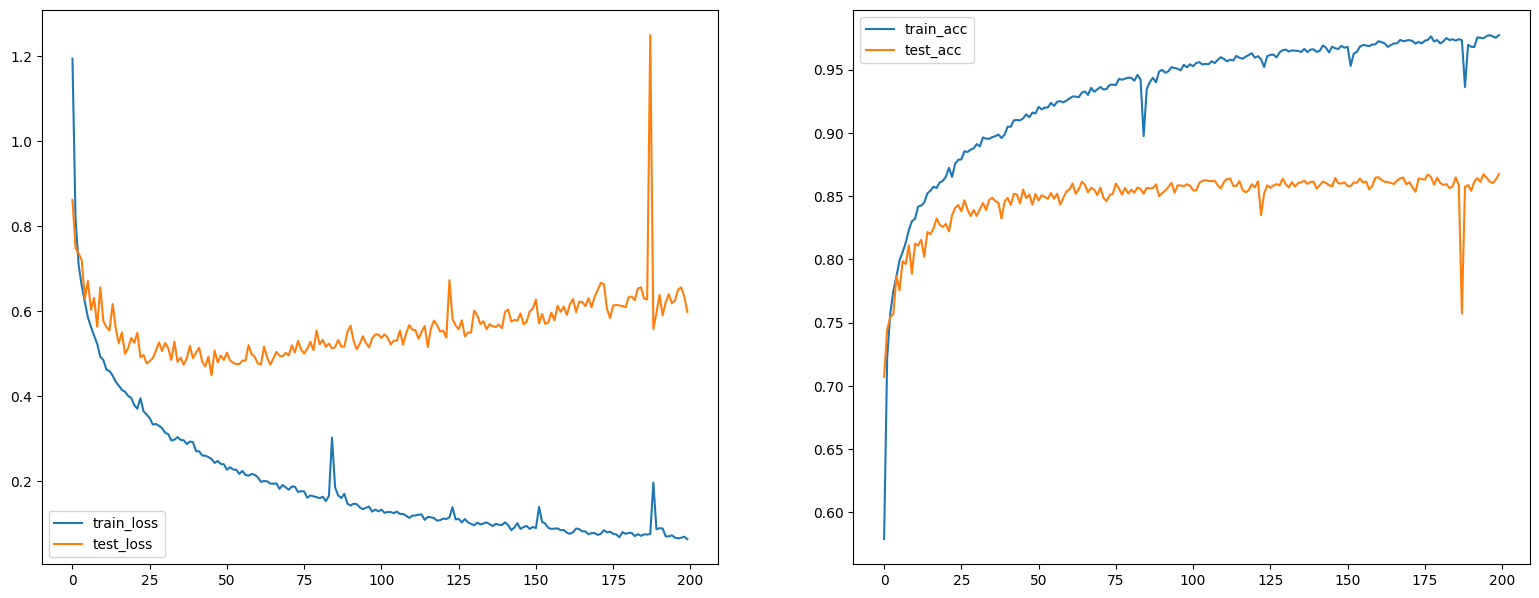

In [ ]:
plt.figure(figsize=(19.2,7.2))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.legend()

plt.show()

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)